# FALLDETEKTOR 2.0
---
### *Introducción a la Inteligencia Artificial*
### *Septiembre de 2019*
## Integrantes

* Daniel Amaris (ddamarisr@unal.edu.co) - Ciencias de la Computacion
* Christian Ortiz (cfortizp@unal.edu.co) - Ingenieria de Sistemas


## Descripción

Uno de los problemas más comunes que tienen los adultos mayores y sus familiares son las caídas. Este problema ha conducido a los adultos mayores a lesiones, discapacidades e incluso la muerte.

Uno de los problemas más graves de las caídas es que la gran mayoría de ellas no son reportadas, se estima que el 80% de las caídas se producen en el hogar y el 20% restante fuera del él, también se sabe que un quinto de los adultos mayores de entre 65 a 69 años, y hasta dos quintos de los mayores de 80, sufren una caída en el último año.

Así mismo existen las principales causas de caídas en el adulto mayor, son de tipo fisiológico, propias del envejecimiento, como la pérdida de masa muscular, disminución de la percepción de sensibilidad profunda, reducción de rango articular, problemas de visión. También se deben a problemas de tipo patológico, enfermedades como el Parkinson, alteraciones de la visión, secuelas de un accidente vascular cerebral y demencia.

Actualmente existen diversos mecanismos para detectar las caídas, dispositivos electrónicos como el Angel4, Elea y Nursecall, pueden llegar a costar 149,95€ alrededor de 560.453,12 COP. También se pueden encontrar en las tiendas virtuales como la Play Store y la App Store aplicaciones como Chk-In Fall y FallDetector que realizan esta tarea.

El principal objetivo de este proyecto es desarrollar en Python un dispositivo capaz de detectar caídas en tiempo real. Para esto se realizó un agente que fue entrenado en diferentes situaciones. A continuación, se hará un reporte sobre el proyecto realizado.

## Metodología

El objetivo principal de nuestro proyecto consiste en interpretar los datos provenientes de un sensor (en este caso el acelerómetro de un celular) y establecer si ha ocurrido una caída. Para tal fin, desarrollamos en nuestro código un módulo encargado de recibir "escuchar" los datos provenientes del celular tales como los datos de aceleración en los tres ejes (x,y,z) y los datos de latitud y longitud correspondientes. Luego desarrollamos un módulo para la comunicación con el usuario (una interfaz) y finalmente diseñamos un módulo para aprendizaje y reconocimiento


### Módulo de captación de datos y filtrado: 

In [1]:
import socket    #for sockets
import sys    #for exit
import numpy as np
import math 
import os #for files
import smtplib #for email
from email.mime.text import MIMEText as text
import matplotlib.pyplot as plt

#global variables
samples=[]
flag=True
standard = 0
mean = 0
gps=(0,0)
counter=0

def listenTo(mode):
    global counter
    global flag
    global firstfall
    global mean
    global standard
    global gps
    samplecounter=0
    host = ''
    port = 5555
    # create dgram udp socket
    try: 
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    except socket.error:    
        print('Failed to create socket')
        sys.exit()
    s.bind((host, port))
    email = "automatedfalldt@gmail.com"
    if (mode=='aplication'):
        email = input("Ingrese su email: ")
    
    while(flag) :
        try:
            d = s.recvfrom(5555)
            reply = d[0]
            stringdata = reply.decode('utf-8')
            stringdata=stringdata.split(',')
            j = 0
            jg = 0 
            for i in range (len(stringdata)):
                if stringdata[i] == " 1":
                    jg = i
                if stringdata[i] == " 3":
                    j = i
                    i = len(stringdata)
                
                    
            x=float(stringdata[j+1].strip())
            y=float(stringdata[j+2].strip())
            z=float(stringdata[j+3].strip())
            lat=float(stringdata[jg+1].strip())
            long=float(stringdata[jg+2].strip())
            if(jg!=0):
                gps = (lat, long)
                print("Se ha detectado una señal de GPS")
            ac=(x,y,z)
            if (mode=='idle'):
                samplecounter=samplecounter+1
                idle(ac,samplecounter)
            
            if (mode=='training'):
                if(counter!=0):
                    counter=counter+1
                if(counter==25):
                    counter=0
                if (magnitude(ac)>mean+12*standard and counter==0):
                    counter=counter+1;
                    training(ac);
               
            if (mode=='aplication'):
                if(counter!=0):
                    counter=counter+1
                if(counter==25):
                    counter=0
                if (magnitude(ac)>mean+12*standard and counter==0):
                    counter=counter+1
                    print("Dato Atipico")
                    if(nearestpoint(ac)=="f"):
                        print("Falldetektor ha detectado una caída")
                        aplication(email)
                #exittag = input("Desea Salir, Y o N: ")
                #if(exittag=="Y" or exittag=="y"):
                    #sys.exit()
                    
        except socket.error:        
            sys.exit

Lo que hacemos en este módulo es comunicarnos con el teléfono por medio del protoculo UDP y recuperar los datos del acelerómetro y el GPS. El teléfono envía los datos como cadenas de Bytes y este código los decodifica y los convierte en Strings para que puedan ser facilmente manipulados. En esta porción de código también implementamos un filtro que ayuda al programa a reconocer los datos atípicos sobre los que se realiza el entrenamiento.

#### Filtrado
Aún en la frecuencia de actualización más baja encontramos que el programa envía varias muestras por cada segundo. Realizar aprendizaje supervisado sobre tantos datos enviados en tan poco tiempo puede resultar ineficaz. Así que implementamos una estrategia para ignorar los datos promedio y concentrarnos en los datos atípicos. Al fin y al cabo, observamos que las caídas siempre generan datos con valores de aceleración muy elevados, pero no todo lo que causaba valores de aceleración elevados era una caída (el entrenamiento seguía estando justificado). Para establecer un criterio confiable que nos permita reconocer un dato atípico, añadimos la siguiente función:

In [2]:
def idle(ac,samplecounter):
    sampleNumber=10000;
    global flag
    if(samplecounter<sampleNumber):
        norm=magnitude(ac)
        samples.append(norm)
    else:
        with open('IdleData.txt', 'w') as f:
            for item in samples:       
                f.write("%s\n" % item)
        f.close()
        
        samplesnp=np.array(samples)
        sd=np.std(samplesnp)
        mean=np.mean(samplesnp)
        print("sd",sd,"mean",mean)
        
        flag=False
        
        with open('stats.txt', 'w') as f:
            for item in (sd,mean):        
                f.write("%s\n" % item)
        f.close()
        

def magnitude(ac):
    mag=math.sqrt(ac[0]**2+ac[1]**2+ac[2]**2)
    mag=round(mag,2)
    return mag

Básicamente, lo que hacemos aquí es calcular la norma de cada vector de un conjunto de 10.000 vectores. Estas 10.000 muestras son recolectadas mientras el sujeto de prueba se encuentra realizando acciones cotidianas como sentarse, subir y bajar escaleras, correr, caminar o estar quieto. Luego, calculamos la media y la desviación estandar de este conjunto de datos y los visualizamos como se muestra en el siguiente histograma:
(Para ver el histograma ejecute la siguiente celda de codigo, el cual toma los datos guardados del muestreo almacenados en el archivo IdleData.txt)

#### Histograma
https://drive.google.com/file/d/1uSvaqt17iOy9GGpd4Jzriv0Wa7eFWyvj/view?usp=sharing

(array([2.800e+01, 1.490e+02, 1.047e+03, 6.099e+03, 2.084e+03, 4.260e+02,
        1.320e+02, 2.200e+01, 1.000e+01, 2.000e+00]),
 array([ 1.36,  3.66,  5.96,  8.26, 10.56, 12.86, 15.16, 17.46, 19.76,
        22.06, 24.36]),
 <a list of 10 Patch objects>)

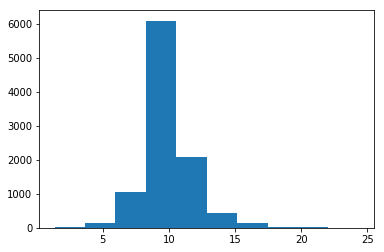

In [3]:
data = []
fil = open("IdleData.txt", "r")
datastatics = fil.readline()
while datastatics != "":
  data.append(float(datastatics.split("\n")[0]))
  datastatics = fil.readline()

plt.hist(data, bins = 10)

El histograma nos confirma algo que muchas veces es una sospecha: los datos están distribuidos normalmente. Esto nos permite reconocer datos atípicos valiéndonos sólo de la media y la desviación estándar obtenidas previamente. En nuestro caso, tras realizar algunas pruebas de campo definimos la siguiente relación para detectar un dato atípico:

![texto alternativo](https://latex.codecogs.com/gif.latex?%5Ctext%7BSi%20%7D%20%5Cleft%20%5C%7C%5Cleft%20%28%20x%2Cy%2Cz%20%5Cright%20%29%20%5Cright%20%5C%7C%3E%20%5Cmu%20&plus;%2012%5Csigma%20%5Ctext%7B%20entonces%20%7D%20%5Cleft%20%28%20x%2Cy%2Cz%20%5Cright%20%29%20%5Ctext%7B%20es%20un%20dato%20atipico.%20%7D%20%5Ctext%7BDonde%20%7D%5Cmu%20%5Ctext%7B%20es%20la%20media%20muestral%20y%20%7D%20%5Csigma%20%5Ctext%7B%20la%20desviacion%20estandar%7D)

Así filtramos los datos y podemos seleccionar sólo más relevantes para  el entrenamiento.


### Módulo de entrenamiento y clasificación:

Con una definición concreta de qué es un dato atípico para nuestra aplicación. Procedemos a dar una breve descripción de cómo entrenamos nuestro modelo y como funciona el sistema de reconocimiento de caídas. 

#### Entrenamiento



In [4]:
def training (ac):
    global flag
    print("SE HA DETECTADO UN DATO INUSUAL!");
    if(os.stat("trainingdata.txt").st_size == 0):
        tag=input("POR FAVOR INDIQUE SI SE HA TRATADO DE UNA CAÍDA Y o N: ")
        mftag = "n"
        if(tag=="y" or tag=="Y"):
            mftag = "f"
        t=str(ac[0])+","+str(ac[1])+","+str(ac[2])+","+mftag
        with open("trainingdata.txt", "a") as myfile:
            myfile.write("%s\n" % t)
    else:
        nearfall = nearestpoint(ac)
        if(nearfall=="f"):
            tag = input("EL PROGRAMA DETECTA QUE ES UNA CAIDA. VERIFIQUE T o F: ")
            if(tag=="F" or tag=="f"):
                nearfall = "n"
        else:
            tag = input("EL PROGRAMA DETECTA QUE NO ES UNA CAIDA. VERIFIQUE T o F: ")
            if(tag=="F" or tag=="f"):
                nearfall = "f"
        t=str(ac[0])+","+str(ac[1])+","+str(ac[2])+","+nearfall
        with open("trainingdata.txt", "a") as myfile:
            myfile.write("%s\n" % t)
        ftag = input("DESEA SEGUIR ENTRENANDO, Y o N: ")
        if(ftag=="N" or ftag=="n"):
            flag = False 
             

La función de entrenamiento es bastante sencilla, cada vez que detectamos un vector de aceleración con una norma elevada (según los criterios definidos en el módulo anterior) lo enviamos como paramétro a la función de entrenamiento. Como estamos hablando de aprendizaje supervisado, lo que hace la función es preguntar al usuario si el vector recibido corresponde a una caída o no. Y de acuerdo con la respuesta le asociamos una etiqueta (identificador) al vector en cuestión. Hacemos esto por cada dato que recibamos en tiempo real, además de guardar los valores (x,y,z,tag) en un archivo que será nuesto trainingSet. 

Además, para entrenar el modelo el sujeto de prueba realizo acciones como sentarse, incorporarse, correr, arrojar el teléfono, subir escaleras, bajar escaleras, sacar el telefono del bolsillo y volver a introducirlo, y caer al suelo. Todo con el ánimo de tener un dataSet lo más completo posible.

#### Clasificación

In [5]:
def nearestpoint(ac):
    f = open("trainingdata.txt", "r")
    st = f.readline()
    minimun = float("inf")
    falltag = "f"
    while (st!="" and st!="\n"):
        st = st.split(",")
        distance = math.sqrt((ac[0]-float(st[0]))**2 + (ac[1]-float(st[1]))**2 + (ac[2]-float(st[2]))**2)
        if(distance < minimun):
            minimun = distance
            fta = st[3].split("\n")[0]
            falltag = fta
        st = f.readline()
    return falltag

La función de clasificación es una simplificación del algoritmo K-Nearest Neighbor. De hecho, es un caso particular del mismo con K=1.

![texto alternativo](https://en.proft.me/media/science/r_knn_classify.png)

Lo que hace la función de clasificación es que dado un vector de aceleración atípico (con norma muy distinta a la media) busca el vector más cercano entre todos los que están almacenados en nuestro trainigSet. Cuando lo encuentre,  busca la etiqueta asociada a ese vector y con base en eso reconoce si el dato ingresado corresponde a una caída o no. 

Como sólo se está realizando clasificación entre dos categorías (caída/no caída) es de esperarse que el algoritmo sea eficaz. Además, luego de cada intento de clasificación le estamos dando retroalimentación al sistema, para confirmar si su respuesta corresponde con la realidad. Esto es útil porque nos ayuda a aumentar la base de datos del entrenamiento.


### Aplicación:


In [6]:
def aplication(email):
    global gps
    global flag
    m = text("FallDetektor 2.0 ha detectado una caida. \nAproximadamente en: http://google.com/maps/place/"+str(gps[0])+","+str(gps[1])+
             "\n \nAtentamente, \nFallDetektor 2.0 Team")
    m['Subject'] = 'Se ha detectado una caída!'
    mail = smtplib.SMTP('smtp.gmail.com',587)
    mail.ehlo()
    mail.starttls()
    mail.login('automatedfalldt@gmail.com',"Spiderman123")
    mail.sendmail('automatedfalldt@gmail.com',email,m.as_string())
    mail.close()
    print("El email se ha enviado corrrectamente")
    exittag = input("Desea Salir, Y o N: ")
    if(exittag=="Y" or exittag=="y"):
        flag = False
    

El código de la aplicación nos sirve para cumplir con los requisitos operacionales del proyecto. Este sencillo código envía una alerta de caída al e-mail que ha especificado el usuario. En la alerta encontraremos las coordenadas en donde se ha producido la caída, además de un link de Google Maps que nos muestra donde están estas coordenadas con imagenes satelitales y mapas.
## Resultados

Una vez el modelo fue entrenado se relaizaron diversas pruebas, de las cuales tuvimos los siguientes resultados, 9 de cada 10 alertas fueron enviados de manera correcta. Se realizaron las siguientes pruebas:

* **Subir Escaleras**
https://drive.google.com/file/d/1JTZxJnC3Dj5-iyfLLSxHxrptU_G9tVYp/view?usp=sharing
https://drive.google.com/file/d/1uZiMWgsTEJoAhPudZNmxQNBCAkI3AEOE/view?usp=sharing

* **Bajar Escaleras** https://drive.google.com/file/d/1wIsjrcYTXCeARpOh8Ocqgi9SME7vdqOv/view?usp=sharing

* **Caminar**
https://drive.google.com/file/d/1jC_46A22GuhfBqeCyU5PGrLuFs_kxI_P/view?usp=sharing

* **Sentarse**
https://drive.google.com/file/d/1cD5sQ-RV3Hp55zAgtc_cQYki8dQ-tIbo/view?usp=sharing

* **Pararse**
https://drive.google.com/file/d/1r4dSnz4okml1nrSJjCPrsAA9BNTM6nKE/view?usp=sharing



### Descripción de los Archivos

* IdleData.txt: En este archivo se almacenan todas las magnitudes de los vectores del muestreo.
* stats.txt: En este archivo se almacena la media y la varianza del muestreo.
* trainingdata.txt: En este archivo se almacenan todos los datos del entrenamiento.

Por ultimo en la funcion menu(), podemos acceder a todas las funcionalidades que tiene el programa.

In [7]:
def menu():
    global standard
    global mean
    if(os.stat("stats.txt").st_size != 0):
        stats = open("stats.txt", "r")
        standard = float(stats.readline().split("\n")[0])
        mean = float(stats.readline().split("\n")[0])
    print("************MAIN MENU************** \n")
    
    print ("Welcome to your silly fall-detection solution.\n ")

    choice = input("""
                      1: Record idle data
                      2: Training
                      3: Aplication
                      4: Exit

                      Please enter your choice: """)

    if (choice == "1") :
        listenTo("idle")
    elif (choice == "2"):
        listenTo("training")
    elif (choice == "3"):
        listenTo("aplication")
    elif (choice == "4"):
        sys.exit
    else:
        print("You must only select either 1,2,3 or 4.")
        print("Please try again")
        menu()


## Ejecucion
Para ejecutar el programa, es necesario correr la siguiente celda de codigo

In [ ]:
menu()

************MAIN MENU************** 

Welcome to your silly fall-detection solution.
 

                      1: Record idle data
                      2: Training
                      3: Aplication
                      4: Exit

                      Please enter your choice: 3
Ingrese su email: fagomezj@gmail.com
Se ha detectado una señal de GPS
Se ha detectado una señal de GPS
Se ha detectado una señal de GPS
Dato Atipico
Falldetektor ha detectado una caída
El email se ha enviado corrrectamente
